# Examen 2 - Parte II b: Selección de modelo (Redes Neuronales)
### Juan David García Hernández 201529083 - César Daniel Garrido Urbano 201531367

El presente notebook contiene el reporte y solución (código) de la segunda parte, de tres, del examen 2 del curso de Machine Learning de la Universidad de los Andes. En este se busca resolver el problema de clasificación multiclase de estados de sueño a partir de lectura de datos de EEG. En esta sección se desea encontrar un modelo que se ajuste de forma adecuada a los datos y sea capaz de cumplir con la tarea de clasificación. Esta parte, a su vez, se divide en dos (a y _b_), en esta segunda parte se exploran modelos computacionalmente demandantes como lo son las redes neuronales. Asimismo, se realiza el trabajo de sintonizar parámetros y ajustar los modelos con el fin de mejorar su error de clasificación. Finalmente, se escoje el modelo con mejor error de validación y con este se predicen las etiquetas reservadas para prueba para posteriormente evaluarlas en la última parte del examen.

### Importación de librerías, lectura de datos y preprocesamiento
En primer lugar se realiza la importación de todas las librerías que se pretenden utilizar para el proceso de selección de modelo enfocado en redes neuronales.

In [31]:
import tensorflow as tf
import numpy as np
import random
import warnings
import sklearn
import keras
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import pandas as pd
warnings.simplefilter("ignore")

Para la lecutra de los archivos separados mediante el script mencionado en el _notebook_ correspondiente a procesamiento y lectura de datos, se utiliza _Numpy_. Cada uno de los arreglos numéricos se guarda en una variable con su mismo nombre.

In [32]:
X = np.genfromtxt('../Data/X.csv', delimiter=',')
Y = np.genfromtxt('../Data/Y.csv', delimiter=',')
XVal = np.genfromtxt('../Data/XVal.csv', delimiter=',')
YVal = np.genfromtxt('../Data/YVal.csv', delimiter=',')
XTest = np.genfromtxt('../Data/XTest.csv', delimiter=',')
YTest = np.genfromtxt('../Data/YTest.csv', delimiter=',')
weigthsY = np.genfromtxt('../Data/weigthsY.csv', delimiter=',')
weigthsYVal = np.genfromtxt('../Data/weigthsYVal.csv', delimiter=',')
print("Data loaded")

Data loaded


Ahora bien, haciendo uso del paquete de preprocesamiento de Sklearn se estandarizan los todos los datos leidos. Cabe resaltar que no se hace un mayor preprocesamiento en los datos dado que podría afirmarse que las mismas redes se encargan de dicho procedimiento.

In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
XTest = scaler.transform(XTest)
XVal = scaler.transform(XVal)
Y = keras.utils.to_categorical(Y)
YVal = keras.utils.to_categorical(YVal)
print("Data normalized")

Data normalized


### Definición de parámetros
Algunos de los parámetros que se variaron se definen a continuación:
1. En primer lugar se varía el número de neuronas entre 200, 500, 750 y 1000. 
2. De igual manera se varía la cantidad de capas ocultas de la red contemplando la posibilidad de 1, 2 y 3 capas ocultas. 
3. Las función de activación de las capas ocultas se varía entre tanh, sigmoide y relu.

Para el caso de la función de activación de la capa de salida se utiliza únicamente una función _softmax_, pues se considera más recomendable a la hora de implementar modelos de clasificación multiclase.

En el presente notebook se presentan variaciones sencillas, con bajo número de neuronas, bajo número de capas y pocas funciones de activación. No obstante, los _scripts_ disponibles en el repositorio referenciado se utilizan para hacer iteraciones más significativas de estos parámetros y acortar el espacio de búsqueda de las mismas. En el archivo _NeuralNetwork/results.csv_ se encuentra el archivo en donde, por medio de persistencia, se realiza el almacenamiento de los resultados obtenidos para varias de las arquitecturas de red y combinación de funciones utilizadas. Es finalmente sobre este archivo que se realiza la búsqueda de los mejores parámetros para el entrenamiendo de la red. Con estos parámetros se entrena un nuevo modelo con el cual se hace la predicción de los datos reservados para la evaluación final del modelo seleccionado.

In [34]:
neurons_num = [20,40,60]
layers_num = [1,2,3]
activation_func = ['tanh', 'sigmoid', 'relu']
exit_func = ['softmax']
epochs = 300
batch_size = 32

#### Método de verificación de acierto
Se implementa el siguiente método para obtener el porcentaje de acierto de cada uno de los modelos implementados. En algunas iteraciones se realiza el entrenamiendo incluyendo un parámetro de pesos que permite dar mayor importancia a los datos de las clases que tienen menos datos. No obstante, no se observa una mejora notable en el resultado.

In [39]:
def get_accuracy_score(y_val, y_train):
    val = list()
    for i in range(len(y_val)):
        val.append(np.argmax(y_val[i]))
    
    train = list()
    for i in range(len(y_train)):
        train.append(np.argmax(y_train[i]))
    
    val_t = list()
    for i in range(len(YVal)):
        val_t.append(np.argmax(YVal[i]))
    
    train_t = list()
    for i in range(len(Y)):
        train_t.append(np.argmax(Y[i]))
    
    a = accuracy_score(val, val_t)
    print("Error de validacion: " + str(round(1 - accuracy_score(val, val_t),3)))
    print("Error de entrenamiento: " + str(round(1 - accuracy_score(train, train_t),3)))
    return a

## Optimización de arquitectura

Para la optimización de la arquitectura de red se procede a variar dos de los parámetros previamente expuestos:
número de neuronas de las capas ocultas y número de capas. Mediante dos ciclos _for_ se realiza la variación cruzada de estos parámetros, se entrena el modelo acorde y se evalúa el resultado del mismo sobre datos de validación. En el presente archivo se realiza una variación disminuida con el fin de mostrar de manera sencilla la estructura utilizada para hacer la variación de parámetros.

Para facilidad en la verificación de los resultados se almacena en un archivo _.csv_ las principales características del modelo al igual que su porcentaje de acierto en los datos de validación.

In [40]:
for i in range(0, len(neurons_num)):
    for j in range(0, len(layers_num)):
        print("Entrenando modelo: " + str(layers_num[j]) + " capas y " + str(neurons_num[i]) + " neuronas.")
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(neurons_num[i], input_dim=len(X[0]), activation=activation_func[0]))
        if (layers_num[i] > 1):
            for  k in range(1, layers_num[j]):
                model.add(keras.layers.Dense(j, activation=activation_func[0]))
        model.add(keras.layers.Dense(4, activation=exit_func[0]))
        # Model compiler
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Trainging
        history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=(XVal, YVal), verbose=0)
        y_val = model.predict(XVal)
        y_train = model.predict(X)
        with open('../NeuralNetwork/results.csv',mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([layers_num[j],neurons_num[i],epochs,activation_func[0],exit_func[0],get_accuracy_score(y_val, y_train)])

Entrenando modelo: 1 capas y 20 neuronas.
Error de validacion: 0.102
Error de entrenamiento: 0.096
Entrenando modelo: 2 capas y 20 neuronas.
Error de validacion: 0.102
Error de entrenamiento: 0.097
Entrenando modelo: 3 capas y 20 neuronas.
Error de validacion: 0.101
Error de entrenamiento: 0.097
Entrenando modelo: 1 capas y 40 neuronas.
Error de validacion: 0.092
Error de entrenamiento: 0.085
Entrenando modelo: 2 capas y 40 neuronas.
Error de validacion: 0.136
Error de entrenamiento: 0.131
Entrenando modelo: 3 capas y 40 neuronas.
Error de validacion: 0.099
Error de entrenamiento: 0.092
Entrenando modelo: 1 capas y 60 neuronas.
Error de validacion: 0.092
Error de entrenamiento: 0.079
Entrenando modelo: 2 capas y 60 neuronas.
Error de validacion: 0.157
Error de entrenamiento: 0.148
Entrenando modelo: 3 capas y 60 neuronas.
Error de validacion: 0.093
Error de entrenamiento: 0.082


## Optimización de funciones de activación
Ahora bien,como se mencionó previamente no se variará la función de activación de la capa de salida. Siempre se utilizará la función _softmax_. Por el contrario, la función de activación de las capas ocultas varía según el vector previamente. Se resalta que se realizaron variaciones con más funciones de activación, sin embargo por cuestiones de procesamiento se utilizan menor cantidad acá. En los scripts adjuntos se evalúa el rendimiento de funciones como _'tanh', 'sigmoid', 'relu', 'identity', 'hard sigmoid', 'exponential'_. Los resultados de esta iteración mayor se encuentran en el documento mencionado.

In [41]:
for i in range(0, len(activation_func)):
    print("Entrenando modelo con " + activation_func[i] + " como función de activación.")
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(neurons_num[2], input_dim=len(X[0]), activation=activation_func[i]))
    model.add(keras.layers.Dense(4, activation=exit_func[0]))
    # Model compiler
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Trainging
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
    # Predict over validation fraction
    y_val = model.predict(XVal)
    y_train = model.predict(X)
    # Save results in csv file
    with open('../NeuralNetwork/results.csv',mode='a') as file:
        writer = csv.writer(file)
        writer.writerow([layers_num[0], neurons_num[2],epochs,activation_func[i],exit_func[0],get_accuracy_score(y_val, y_train)])

Entrenando modelo con tanh como función de activación.
Error de validacion: 0.09
Error de entrenamiento: 0.08
Entrenando modelo con sigmoid como función de activación.
Error de validacion: 0.089
Error de entrenamiento: 0.079
Entrenando modelo con relu como función de activación.
Error de validacion: 0.087
Error de entrenamiento: 0.08


## Optimización del algoritmo de aprendizaje
Otro de los parámetros sobre los que se hizo una búsqueda exhaustiva buscando el mejor desempeño fue el algoritmo de aprendizaje. Mediante la librería Sklearn se entrenan 3 modelos con los mismos parámetros, excepto el algoritmo. La librería mencionada ofrece la posibildiad de de entrenar modelos con 5 algoritmos diferentes: _sgd_ (Stochastic gradient descent) _adam_ (opimizer SGD) y _lbfgs_ (Quasi-Newton). En cada uno se define una fracción de entrenamiento de 0, puesto que los procesos de validación se realizan manualmente.

En los scripts adjutnos en el _respositorio_ previamente referenciado se realiza esta misma búsqueda pero variando igualmente el número de neuronas de la única capa oculta del modelo. No obstante, por cuestiones de procesamiento en este _notebook_ se muestra el proceso únicamente para un número definido de neuronas. 

Los _scritps_ ejecutados localmente que se encuentran en el repositorio referenciados muestran que el mejor resultado se obtiene con el algoritmo de Newton, no obstante, dado que la diferencia en porcentaje de acierto es poca y que el tiempo de ejecución es notablemente mayor, se procede a entrenar todas las redes con el algotirmo de optimización Adam.

In [43]:
algs=['adam', 'sgd', 'lbfgs']
training_error = []
val_error = []
weighted_error = []
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(neurons_num[1],), max_iter=700, validation_fraction=0)
clf.fit(X, Y)
training_error.append(clf.score(X, Y))
val_error.append(clf.score(XVal, YVal))
weighted_error.append(clf.score(XVal, YVal, sample_weight=weigthsYVal))

clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(neurons_num[1],), batch_size=1, max_iter=600, validation_fraction=0)
clf.fit(X, Y)
training_error.append(clf.score(X, Y))
val_error.append(clf.score(XVal, YVal))
weighted_error.append(clf.score(XVal, YVal, sample_weight=weigthsYVal))

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(neurons_num[1],), max_iter=700, validation_fraction=0)
clf.fit(X, Y)
training_error.append(clf.score(X, Y))
val_error.append(clf.score(XVal, YVal))
weighted_error.append(clf.score(XVal, YVal, sample_weight=weigthsYVal))

print("El mejor resultado se obtuvo con " + str(algs[np.argmax(val_error)]) + " con " + str(round(np.max(val_error),3)) + "% de acierto.")

El mejor resultado se obtuvo con adam con 0.878% de acierto.


Con base en cada uno de los modelos previamente entrenados se obtiene el error sobre datos de entrenamiento y de validación y se grafican los resultados correspondientes.

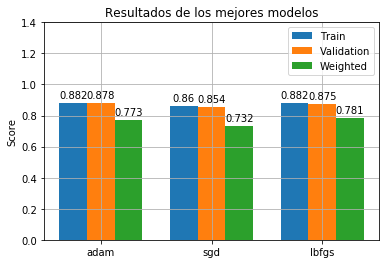

In [44]:
 # Gráfica de resumen
models = algs
trainScore = [round(training_error[0],3),  round(training_error[1],3), round(training_error[2],3)]
valScore = [round(val_error[0],3), round(val_error[1],3), round(val_error[2],3)]
weightScore = [round(weighted_error[0],3), round(weighted_error[1],3) , round(weighted_error[2],3)]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, trainScore, width, label='Train')
rects2 = ax.bar(x, valScore, width, label='Validation')
rects3 = ax.bar(x + width, weightScore, width, label='Weighted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Resultados de los mejores modelos')
ax.set_xticks(x)
ax.set_ylim(0,1.4)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.grid()
plt.show()

## Archivo de persistencia

Como se mencionó previamente la búsqueda de la red con la mejor arquitectura se realiza con base en el archivo _results.csv_ que se ha ido actualizando con base en todas las iteraciones realizadas. Cabe resaltar que varios modelos fueron ejecutados varias veces a lo largo del proceso de selección. Con el fin de no editar manualmente el archivo se repiten algunos de dichos modelos.

Como siguiente paso en el _Notebook_ se realiza la lectura del archivo mediante la librería pandas.

In [48]:
df = pd.read_csv('../NeuralNetwork/results.csv')
warnings.simplefilter("ignore")
print("Total de modelos evaluados: " + str(len(df))+ "\n \n")
best_accuracy = df.loc[df['Acierto'].argmax()]
print(best_accuracy)
df.sort_values(by=['Acierto'])

Total de modelos evaluados: 126
 

Capas                 1
Neuronas             60
Epocas              300
Func_Act        sigmoid
Func_Salida     softmax
Acierto        0.913456
Name: 82, dtype: object


Capas  Neuronas  Epocas Func_Act Func_Salida   Acierto
32       2        40     300     tanh     softmax  0.795471
35       2        60     300     tanh     softmax  0.810605
121      2        60     300     tanh     softmax  0.842813
79       2        60     300     tanh     softmax  0.842932
41       1      1000     225     tanh     softmax  0.851346
44       3        10     100     tanh     softmax  0.857768
42       1        10     100     tanh     softmax  0.859050
106      2        40     300     tanh     softmax  0.859228
43       2        10     100     tanh     softmax  0.862196
118      2        40     300     tanh     softmax  0.863539
27       5       200     225     tanh     softmax  0.863958
109      2        60     300     tanh     softmax  0.864805
76       2        40     300     tanh     softmax  0.864805
100      5       100     225     tanh     softmax  0.864885
98       5        90     225     tanh     softmax  0.865328
16       6       100     225     tanh     softmax  0.866864
101      6       100     225     tanh     softmax  0.867500
97       6        80     225     tanh     softmax  0.868109
96       5        80     225     tanh     softmax  0.868375
22       3       700     225     tanh     softmax  0.870209
99       6        90     225     tanh     softmax  0.870401
93       6        60     225     tanh     softmax  0.870415
45       1        20     100     relu     softmax  0.870446
94       5        70     225     tanh     softmax  0.871136
90       5        50     225     tanh     softmax  0.872957
48       1        30     100     relu     softmax  0.873454
88       5        40     225     tanh     softmax  0.873512
95       6        70     225     tanh     softmax  0.873723
25       3       900     225     tanh     softmax  0.874047
46       2        20     100     relu     softmax  0.875477
..     ...       ...     ...      ...         ...       ...
115      2        20     300     tanh     softmax  0.897912
114      1        20     300     tanh     softmax  0.898070
74       3        20     300     tanh     softmax  0.898268
73       2        20     300     tanh     softmax  0.898347
103      2        20     300     tanh     softmax  0.898347
72       1        20     300     tanh     softmax  0.898584
116      3        20     300     tanh     softmax  0.898624
104      3        20     300     tanh     softmax  0.899296
26       1      1000     225     tanh     softmax  0.900179
110      3        60     300     tanh     softmax  0.900285
119      3        40     300     tanh     softmax  0.901036
80       3        60     300     tanh     softmax  0.902579
107      3        40     300     tanh     softmax  0.902974
77       3        40     300     tanh     softmax  0.905348
122      3        60     300     tanh     softmax  0.906653
75       1        40     300     tanh     softmax  0.906732
105      1        40     300     tanh     softmax  0.906930
120      1        60     300     tanh     softmax  0.907958
117      1        40     300     tanh     softmax  0.908354
83       1        60     300     relu     softmax  0.908354
108      1        60     300     tanh     softmax  0.909343
113      1        60     300     relu     softmax  0.909699
81       1        60     300     tanh     softmax  0.909896
123      1        60     300     tanh     softmax  0.909975
78       1        60     300     tanh     softmax  0.910846
124      1        60     300  sigmoid     softmax  0.911202
111      1        60     300     tanh     softmax  0.911755
125      1        60     300     relu     softmax  0.912626
112      1        60     300  sigmoid     softmax  0.912744
82       1        60     300  sigmoid     softmax  0.913456

[126 rows x 6 columns]

Se busca el argumento que maximiza el porcentaje de acierto del modelo en datos de validación y se imprimen los resultados. Con base en ello se entrena nuevamente el modelo descrito y se obtiene la predicción de la clasificación de los datos de _Test_ la cual se almacena en un archivo con el nombre respectivo. Este archivo se lee desde el cuarto _notebook_ con el fin de evitar reentrenar el modelo nuevamente.

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(int(best_accuracy['Neuronas']), input_dim=len(X[0]), activation=best_accuracy['Func_Act']))
if int(best_accuracy['Capas']) > 2:
    for i in range(1, best_accuracy['Capas']):
        model.add(keras.layers.Dense(int(best_accuracy['Neuronas']), activation=best_accuracy['Func_Act']))
model.add(keras.layers.Dense(4, activation=best_accuracy['Func_Salida']))
# Model compiler
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Trainging
history = model.fit(X, Y, epochs=best_accuracy['Epocas'], batch_size=32, sample_weight=weigthsY)

Epoch 1/300
202251/202251 [==============================] - 8s 40us/step - loss: 7.9702e-06 - acc: 0.7977
Epoch 2/300
202251/202251 [==============================] - 7s 36us/step - loss: 6.5402e-06 - acc: 0.8269
Epoch 3/300
202251/202251 [==============================] - 7s 33us/step - loss: 6.1700e-06 - acc: 0.8366
Epoch 4/300
202251/202251 [==============================] - 7s 33us/step - loss: 5.9399e-06 - acc: 0.8420
Epoch 5/300
202251/202251 [==============================] - 7s 33us/step - loss: 5.7649e-06 - acc: 0.8471
Epoch 6/300
202251/202251 [==============================] - 7s 34us/step - loss: 5.6269e-06 - acc: 0.8503
Epoch 7/300
202251/202251 [==============================] - 7s 35us/step - loss: 5.5115e-06 - acc: 0.8532
Epoch 8/300
202251/202251 [==============================] - 9s 44us/step - loss: 5.4081e-06 - acc: 0.8565
Epoch 9/300
202251/202251 [==============================] - 7s 35us/step - loss: 5.3285e-06 - acc: 0.8590
Epoch 10/300
202251/202251 [=========

202251/202251 [==============================] - 6s 32us/step - loss: 4.3025e-06 - acc: 0.8878
Epoch 77/300
202251/202251 [==============================] - 7s 32us/step - loss: 4.3045e-06 - acc: 0.8872
Epoch 78/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.2968e-06 - acc: 0.8882
Epoch 79/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.2993e-06 - acc: 0.8880
Epoch 80/300
202251/202251 [==============================] - 7s 34us/step - loss: 4.2887e-06 - acc: 0.8881
Epoch 81/300
202251/202251 [==============================] - 7s 35us/step - loss: 4.2864e-06 - acc: 0.8885
Epoch 82/300
202251/202251 [==============================] - 7s 35us/step - loss: 4.2820e-06 - acc: 0.8884
Epoch 83/300
202251/202251 [==============================] - 7s 35us/step - loss: 4.2800e-06 - acc: 0.8885
Epoch 84/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.2826e-06 - acc: 0.8882
Epoch 85/300
202251/202251 [=============

202251/202251 [==============================] - 7s 33us/step - loss: 4.1322e-06 - acc: 0.8926
Epoch 152/300
202251/202251 [==============================] - 7s 34us/step - loss: 4.1341e-06 - acc: 0.8923
Epoch 153/300
202251/202251 [==============================] - 9s 43us/step - loss: 4.1348e-06 - acc: 0.8924
Epoch 154/300
202251/202251 [==============================] - 7s 35us/step - loss: 4.1259e-06 - acc: 0.8923
Epoch 155/300
202251/202251 [==============================] - 7s 35us/step - loss: 4.1296e-06 - acc: 0.8927
Epoch 156/300
202251/202251 [==============================] - 6s 31us/step - loss: 4.1283e-06 - acc: 0.8923
Epoch 157/300
202251/202251 [==============================] - 6s 31us/step - loss: 4.1251e-06 - acc: 0.8923
Epoch 158/300
202251/202251 [==============================] - 7s 32us/step - loss: 4.1237e-06 - acc: 0.8922
Epoch 159/300
202251/202251 [==============================] - 6s 31us/step - loss: 4.1225e-06 - acc: 0.8924
Epoch 160/300
202251/202251 [====

202251/202251 [==============================] - 7s 32us/step - loss: 4.0434e-06 - acc: 0.8942
Epoch 227/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.0480e-06 - acc: 0.8947
Epoch 228/300
202251/202251 [==============================] - 6s 32us/step - loss: 4.0417e-06 - acc: 0.8948
Epoch 229/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.0447e-06 - acc: 0.8943
Epoch 230/300
202251/202251 [==============================] - 7s 36us/step - loss: 4.0445e-06 - acc: 0.8946
Epoch 231/300
202251/202251 [==============================] - 7s 34us/step - loss: 4.0383e-06 - acc: 0.8947
Epoch 232/300
202251/202251 [==============================] - 7s 34us/step - loss: 4.0346e-06 - acc: 0.8950
Epoch 233/300
202251/202251 [==============================] - 7s 34us/step - loss: 4.0379e-06 - acc: 0.8948
Epoch 234/300
202251/202251 [==============================] - 7s 33us/step - loss: 4.0393e-06 - acc: 0.8944
Epoch 235/300
202251/202251 [====

In [47]:
prediction=[]
for i in range(len(y_pred)):
    prediction.append(np.argmax(y_pred[i]))
np.savetxt("../Data/NNPred.csv", prediction, delimiter=',')